### Data Set Selection

Data Set : MNIST Original\
Numbers Data set\
Source: https://www.kaggle.com/datasets/avnishnish/mnist-original/discussion?sort=hotness
Target: Multiclass Classification



### Part 1

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from scipy.io import loadmat

# Load MNIST
mnist = loadmat("mnist-original.mat")
mnist_data = mnist["data"].T
mnist_label = mnist["label"][0].reshape(-1, 1)  # shape (70000, 1)

# Normalize pixel values
mnist_data = mnist_data / 255.0

# One-hot encode labels
encoder = OneHotEncoder(sparse_output=False)
mnist_label_onehot = encoder.fit_transform(mnist_label)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(mnist_data, mnist_label_onehot, test_size=0.2, random_state=42)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)


X_train shape: (56000, 784)
y_train shape: (56000, 10)


### Single Layer Neural Network (From Scratch)

In [2]:
import numpy as np

class NeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size, learning_rate=0.1, seed=42):
        np.random.seed(seed)
        self.learning_rate = learning_rate

        self.w1 = np.random.randn(input_size, hidden_size) * 0.1
        self.b1 = np.zeros(hidden_size)

        self.w2 = np.random.randn(hidden_size, output_size) * 0.1
        self.b2 = np.zeros(output_size)

    def relu(self, x):
        return np.maximum(0, x)

    def relu_derivative(self, x):
        return (x > 0).astype(float)

    def softmax(self, x):
        e_x = np.exp(x - np.max(x, axis=1, keepdims=True))  # stability trick
        return e_x / np.sum(e_x, axis=1, keepdims=True)

    def forward_prop(self, X):
        self.z1 = np.dot(X, self.w1) + self.b1
        self.a1 = self.relu(self.z1)
        self.z2 = np.dot(self.a1, self.w2) + self.b2
        self.a2 = self.softmax(self.z2)  # softmax for multi-class
        return self.a2

    def back_prop(self, X, y, y_pred):
        m = X.shape[0]

        # Softmax + CCE gradient simplification
        output_delta = y_pred - y  # (no activation derivative needed)

        hidden_error = np.dot(output_delta, self.w2.T)
        hidden_delta = hidden_error * self.relu_derivative(self.z1)

        # Update weights and biases
        self.w2 -= self.learning_rate * np.dot(self.a1.T, output_delta) / m
        self.b2 -= self.learning_rate * np.mean(output_delta, axis=0)
        self.w1 -= self.learning_rate * np.dot(X.T, hidden_delta) / m
        self.b1 -= self.learning_rate * np.mean(hidden_delta, axis=0)

    def fit(self, X, y, epochs, verbose=False):
        cost_history = []
        for epoch in range(epochs):
            y_pred = self.forward_prop(X)
            cost = self.cross_entropy_cost(y, y_pred)
            cost_history.append(cost)
            self.back_prop(X, y, y_pred)

            if verbose and epoch % 100 == 0:
                print(f"Epoch {epoch}, Cost: {cost:.4f}")
        return cost_history

    def cross_entropy_cost(self, y, y_pred):
        y_pred = np.clip(y_pred, 1e-12, 1 - 1e-12)
        return -np.mean(np.sum(y * np.log(y_pred), axis=1))  # Categorical cross-entropy

    def predict(self, X):
        probabilities = self.forward_prop(X)
        return np.argmax(probabilities, axis=1)  # Return class with highest prob


### Training Neural Network

In [3]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

input_size = X_train.shape[1]
model = NeuralNetwork(input_size=input_size, hidden_size=128, output_size=10, learning_rate=0.01)

# Train
costs = model.fit(X_train, y_train, epochs=1000, verbose=True)

# Predict
y_pred_classes = model.predict(X_test)
y_test_classes = np.argmax(y_test, axis=1)

# Evaluate
accuracy = accuracy_score(y_test_classes, y_pred_classes)
precision = precision_score(y_test_classes, y_pred_classes, average='macro')
recall = recall_score(y_test_classes, y_pred_classes, average='macro')
f1 = f1_score(y_test_classes, y_pred_classes, average='macro')

print("\nResults:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


Epoch 0, Cost: 2.5409
Epoch 100, Cost: 1.6743
Epoch 200, Cost: 1.2255
Epoch 300, Cost: 0.9599
Epoch 400, Cost: 0.8021
Epoch 500, Cost: 0.7020
Epoch 600, Cost: 0.6341
Epoch 700, Cost: 0.5852
Epoch 800, Cost: 0.5482
Epoch 900, Cost: 0.5193

Results:
Accuracy: 0.8705714285714286
Precision: 0.8691304219740486
Recall: 0.8685421074520343
F1 Score: 0.8684601859910707


### Evaluation
The model tends to do fairly well, and the recall score shows that it is able to get false positives pretty well. Lets graph this out to get a better idea.

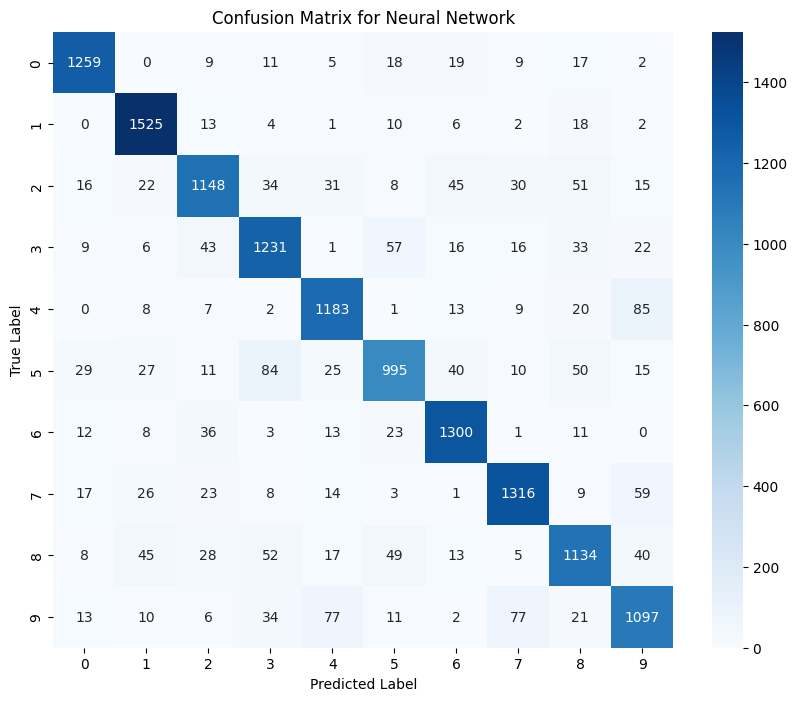

In [4]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

y_pred = model.predict(X_test)
y_true_classes = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Neural Network')
plt.show()

### Research on PyTorch Framework for Implementing a 2-Layer Neural Network
For this project, I chose to use Pytorch. I have little prior experience with Pytorch so I conducted research to understand how it can be used to implement a simple feedforward neural network with 1 hidden and 1 output layer.

1. https://docs.pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html

This tutorial introduced the fundamental way to define a model using nn.Module, which is the recommended approach in Pytorch for constructing neural networks. It showed how to create layers, activate them, and organize everything into a clean class-based structure.

2. https://docs.pytorch.org/docs/stable/autograd.html

This taught me how gradients are calculated automatically during backproagation. PyTorch keeps track of all operations with requires_grad.

3. https://docs.pytorch.org/docs/stable/nn.html#loss-functions

I used this to select and apply the right loss function for a multi-class classification problem. I learned to use nn.CrossEntropyLoss.

4. https://docs.pytorch.org/docs/stable/generated/torch.nn.functional.one_hot.html

I used this link to learn about one hot encoders, which were important for better representing my labels.

### Exploratory Data Analysis

I began with exploratory data analysis in part 1 by loading the data set using scipy.io.loadmat. The dataset contains 70,000 grayscale images of handwritten digits (0-9) each represented as a 28x28 pixel in a 784 dimensional vector. I visualized 5x5 grid of some of these digits. The pixel values were normalized to the range (0,1) by dividng by 255 to improve the stability during training. The labels were then one-hot encoded using OneHotEncoder.

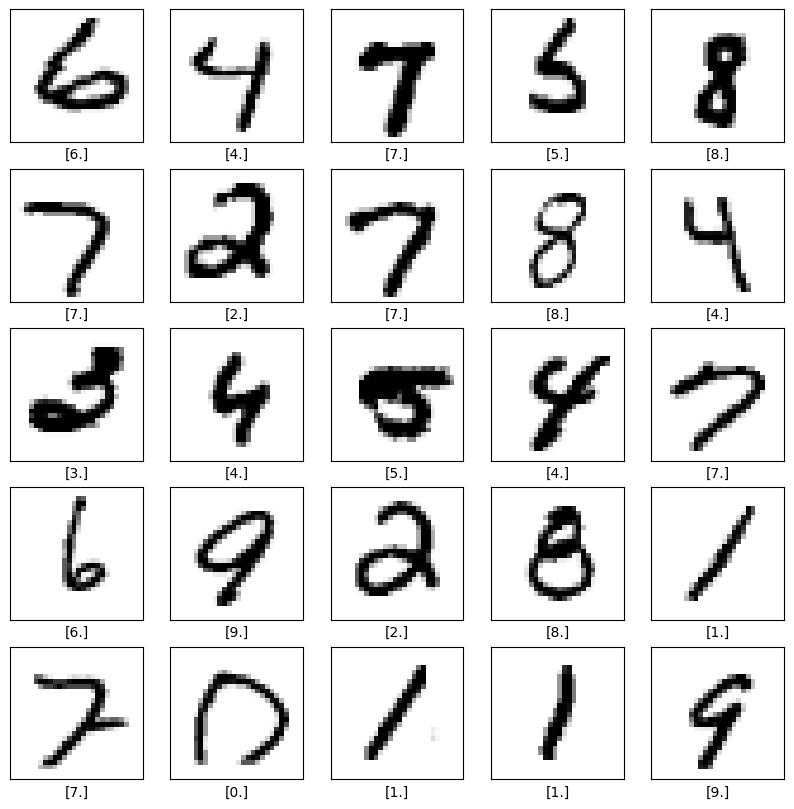

X_train shape: (56000, 784)
y_train shape: (56000, 10)


In [5]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from scipy.io import loadmat

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import torch.optim as optim


# Load MNIST
mnist = loadmat("mnist-original.mat")
mnist_data = mnist["data"].T
mnist_label = mnist["label"][0].reshape(-1, 1)  # shape (70000, 1)

visualizing_data = mnist_data.reshape(len(mnist_data), 28, 28, 1)

def plot_images_sample(X, Y):
    # Draw plot for images sample
    
    plt.figure(figsize=(10,10))
    rand_indicies = np.random.randint(len(X), size=25)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        index = rand_indicies[i]
        plt.imshow(np.squeeze(X[index]), cmap=plt.cm.binary)
        plt.xlabel(Y[index])
    plt.show()

plot_images_sample(visualizing_data, mnist_label)

# Normalize pixel values
mnist_data = mnist_data / 255.0

# One-hot encode labels
encoder = OneHotEncoder(sparse_output=False)
mnist_label_onehot = encoder.fit_transform(mnist_label)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(mnist_data, mnist_label_onehot, test_size=0.2, random_state=42)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

To better understand the balance of digits in the data set, I visualized the label distribution.

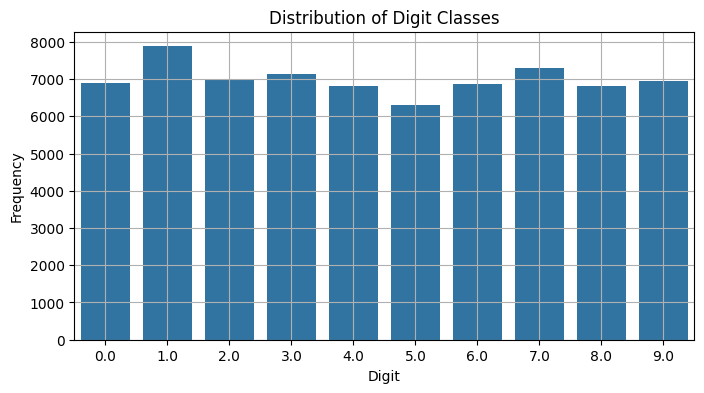

In [6]:
import seaborn as sns

unique, counts = np.unique(mnist_label, return_counts=True)
plt.figure(figsize=(8, 4))
sns.barplot(x=unique, y=counts)
plt.title("Distribution of Digit Classes")
plt.xlabel("Digit")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [7]:
y_train_labels = np.argmax(y_train, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_labels, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_labels, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

In [8]:
class TwoLayerNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(TwoLayerNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [9]:
model = TwoLayerNN(input_size=784, hidden_size=128, output_size=10)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

for epoch in range(10):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        #resets gradient
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader):.4f}")

model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(y_batch.numpy())
        y_pred.extend(predicted.numpy())

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print("Accuracy:", accuracy_score(y_true, y_pred))

Epoch 1, Loss: 0.3527
Epoch 2, Loss: 0.1658
Epoch 3, Loss: 0.1170
Epoch 4, Loss: 0.0881
Epoch 5, Loss: 0.0697
Epoch 6, Loss: 0.0563
Epoch 7, Loss: 0.0455
Epoch 8, Loss: 0.0376
Epoch 9, Loss: 0.0304
Epoch 10, Loss: 0.0261
Accuracy: 0.975


### Evaluation and Conclusion
For the hyperparameters that I tuned during this proces were the hidden layer size, learning rate, batch size, the number of epochs, and what optimizer I would use (experimeneted with both SGD and Adam). These were the easiest to change as I could experiement with the numbers and see what gave a better result. When testing different optimization algorithms, I saw that Adams was the best due to it being generally faster and easier to work with, in the sense that SGD required more fine tuning with the learning rates and I needed more epochs for a similar level of accuracy. I did not use regularization for this because the dataset was relatively balanced. I tested dropout and L2 regularization but didn't see any improvements.